# IBM Data Science Professional Specialization - Coursera
 
This notebook is for the capstone project for the 9-courses specialization in Data Science of IBM. Platform Coursera. ( Data Science Specialization ) 


## Feddah Alotaibi 
LinkedIn: feddah-alotaibi


# 1. project Introduction and Business Problem¶ :

## Introduction:
Jeddah is one of the main cities in Saudi Arabia. It's not that big city but it has many restaurants, cafes and shops. For people that are new to Jeddah, despite its small geographic size, it can be difficult to decide what restaurants are worth going to and where they are. As well as for people living in Jeddah, where shall they go to get food. 


## Business Problem:
For this project, I will create a gudie for people to discover Jeddah's restaurants based on foursquare likes, restaurant category and geographic location data.Then I will group theses restaurants to show how similar they are and to help people decide what restaurant the would go to based to foursquare's information. The question is how similar are Jeddah's restaurants and what are their characteristics. 


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 

In [3]:
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/feddah/anaconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.8                |           py37_0         3.0 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    conda-package-handling-1.3.11|           py37_0         257 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTALLED:

    conda-package-handling: 1.3.11-py37_0 cond

# - importing libraries 


In [24]:
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium
from urllib.request import urlopen
from bs4 import BeautifulSoup
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# - Getting Jeddah's geographic data

In [27]:
address = 'Jeddah, Saudi Arabia'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jeddah are {}, {}.'.format(latitude, longitude))

/Users/feddah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Jeddah are 21.5822247, 39.1640396.


#  - Foursquare data 

In [28]:
CLIENT_ID = 'ZNT5NRJKR54SOV1E4KSV0OTM25OB13EWHH3YP3XLIPV5I1VD' # my Foursquare ID
CLIENT_SECRET = 'XEPIUVYW12HH01JSU3ASRBAIUP5BFH1OMIRC2P203F1NW5EA' # my Foursquare Secret
VERSION = '20180505' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZNT5NRJKR54SOV1E4KSV0OTM25OB13EWHH3YP3XLIPV5I1VD
CLIENT_SECRET:XEPIUVYW12HH01JSU3ASRBAIUP5BFH1OMIRC2P203F1NW5EA


# - Preparing to extract data from Foursquare 

In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ZNT5NRJKR54SOV1E4KSV0OTM25OB13EWHH3YP3XLIPV5I1VD&client_secret=XEPIUVYW12HH01JSU3ASRBAIUP5BFH1OMIRC2P203F1NW5EA&v=20180505&ll=21.5822247,39.1640396&radius=500&limit=100'

In [30]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d31c64cbe70780039a1262b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'As Salamah',
  'headerFullLocation': 'As Salamah, Jeddah',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 69,
  'suggestedBounds': {'ne': {'lat': 21.586724704500007,
    'lng': 39.16886984804075},
   'sw': {'lat': 21.577724695499995, 'lng': 39.159209351959255}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fd0fdabe4b0a91cca68bfc2',
       'name': 'Al Mahawi Sweets || حلويات المهاوي',
       'location': {'address': 'Sari St.',
        'lat': 21.580724489603817,
        'lng': 39.163461555471315,
        'labeledLatLngs': [{'label': 'display',
       

In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Al Mahawi Sweets || حلويات المهاوي,4fd0fdabe4b0a91cca68bfc2,Dessert Shop,21.580724,39.163462
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797
3,Talah Aljood (تالة الجود),4e36ab0a1838f85189b354f2,Dessert Shop,21.579704,39.161000
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137
6,Centro Hotel,5bdedd29364d97002cadd0b1,Hotel,21.585426,39.163594
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761
8,El Malky (المالكي),5894a0b55289305ef7181d2c,Dessert Shop,21.580883,39.160253
9,Fitness Time (وقت اللياقة),51b77966498e859b5ab24c0e,Gym / Fitness Center,21.585313,39.161329


In [33]:
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Al Mahawi Sweets || حلويات المهاوي,4fd0fdabe4b0a91cca68bfc2,Dessert Shop,21.580724,39.163462
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797
3,Talah Aljood (تالة الجود),4e36ab0a1838f85189b354f2,Dessert Shop,21.579704,39.161000
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137
6,Centro Hotel,5bdedd29364d97002cadd0b1,Hotel,21.585426,39.163594
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761
8,El Malky (المالكي),5894a0b55289305ef7181d2c,Dessert Shop,21.580883,39.160253
9,Fitness Time (وقت اللياقة),51b77966498e859b5ab24c0e,Gym / Fitness Center,21.585313,39.161329


In [34]:

nearby_venues['categories'].unique()

array(['Dessert Shop', 'Middle Eastern Restaurant',
       'Fast Food Restaurant', 'Thai Restaurant', 'Café', 'Hotel',
       'Gym / Fitness Center', 'Sushi Restaurant',
       'Health & Beauty Service', 'Sandwich Place', 'Hookah Bar',
       'Breakfast Spot', 'Ice Cream Shop', 'Convenience Store',
       'Chinese Restaurant', 'Health Food Store', 'Supermarket',
       'Pizza Place', 'BBQ Joint', 'Seafood Restaurant', 'Flower Shop',
       'Pool', 'Burger Joint', 'Grocery Store', 'Bakery', 'Hotel Bar',
       'Asian Restaurant', 'Wedding Hall', 'Shoe Store',
       'Fried Chicken Joint', 'Egyptian Restaurant', 'ATM',
       'Cosmetics Shop', 'Boutique'], dtype=object)

In [36]:
# remove stuff that arent cafe or restaurants 
removal_list = ['Dessert Shop', 'Hotel',
       'Gym / Fitness Center',
       'Health & Beauty Service', 'Hookah Bar', 'Ice Cream Shop', 'Convenience Store', 'Health Food Store', 'Supermarket',
       'Flower Shop',
       'Pool', 'Grocery Store', 'Bakery', 'Hotel Bar',
       'Wedding Hall', 'Shoe Store', 'ATM',
       'Cosmetics Shop', 'Boutique']


nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761
12,ASHI SUSHI & Takoyaki,57f24a61498e8000de659d45,Sushi Restaurant,21.581888,39.159764
15,Subway (صب واي),5750422e498ed111af319adc,Sandwich Place,21.585298,39.161312
17,Abo Zaid (ابوزيد),520aee9511d2f4f58c2e052d,Breakfast Spot,21.582303,39.159613
18,Rokon Al Zorbian (ركن الزربيان),4f018a6ae5faf2869d4c7365,Middle Eastern Restaurant,21.581506,39.159932
21,Radi Hilal (راضي هلال),4d20bb54d7b0b1f7bc32179f,Middle Eastern Restaurant,21.582641,39.159502


In [37]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['4bfdef184cf820a13246edf4',
 '4e5fea7a18a8ce02fbbdb814',
 '4bed9b49e3562d7f6346fff8',
 '5104c6b3e4b048e6f6b578b7',
 '4ea088548b810332abf3ff98',
 '57f24a61498e8000de659d45',
 '5750422e498ed111af319adc',
 '520aee9511d2f4f58c2e052d',
 '4f018a6ae5faf2869d4c7365',
 '4d20bb54d7b0b1f7bc32179f',
 '4ef4ca4a9a528bc5d8c632ce',
 '50cf00c9e4b0cbbce0cb2eed',
 '5117da32e4b0665ce9b44de2',
 '5033be23e4b0ee26f2c2f339',
 '4cfd6b52d8468cfaa2f5ff6b',
 '51e2b27d498e7b1ebfae3260',
 '4f00d614be7bbcd4f4807a28',
 '4ea175752c5b5cb4f38f1f82',
 '5432c09b498e66916685e285',
 '58986097fc73d40beda172e7',
 '4d14cc56816af04d31cb3ec2',
 '4e8f62dedab46521c0a59c9a',
 '5601b396498e6f2bedc79bff',
 '55c7bb12498e01d9edb902d9',
 '4bcde4c38920b713d97ea0dc',
 '4e41b72e887719193960ef3a',
 '4feca92de4b04b0c8d2046f9',
 '4ee6d2a361aff5a344082e01',
 '5b294bd25d891b0039de0c76',
 '53fc9a65498e72388cd9e483',
 '57b78fc4498e172dc9469ce3',
 '4f42c2e8e4b029502ba5107c',
 '5813c32a38fa25270e18127c']

In [38]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[94, 262, 241, 248, 176, 35, 20, 92, 14, 110, 9, 17, 15, 18, 100, 28, 89, 194, 19, 10, 21, 5, 12, 10, 6, 10, 8, 4, 6, 4, 4, 1, 4]


In [39]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

33
33


In [40]:
jeddah_venues = nearby_venues2.copy()
jeddah_venues.head()

,name,id,categories,lat,lng
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761


In [41]:
# add in the list of likes

jeddah_venues['total likes'] = like_list
jeddah_venues.head()

,name,id,categories,lat,lng,total likes
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176


# - Describe venues in Jeddah based on # of likes 

In [42]:
print(jeddah_venues['total likes'].max())
print(jeddah_venues['total likes'].min())
print(jeddah_venues['total likes'].median())
print(jeddah_venues['total likes'].mean())

262
1
17.0
57.15151515151515


# - Histogram 

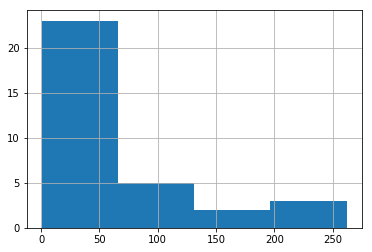

In [44]:
import matplotlib.pyplot as plt
jeddah_venues['total likes'].hist(bins=4)
plt.show()

In [45]:
 #what are the bins we want to use?

print(np.percentile(jeddah_venues['total likes'], 25))
print(np.percentile(jeddah_venues['total likes'], 50))
print(np.percentile(jeddah_venues['total likes'], 75))


8.0
17.0
92.0


In [46]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = jeddah_venues['total likes']<=8
below_avg = jeddah_venues[(jeddah_venues['total likes']>8) & (jeddah_venues['total likes']<=17)]
abv_avg = jeddah_venues[(jeddah_venues['total likes']>45) & (jeddah_venues['total likes']<=92)]
great = jeddah_venues['total likes']>92

### - Categorize the restaurants based on # of likes 

In [48]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=8:
        return 'poor'
    if s['total likes']<=17:
        return 'below avg'
    if s['total likes']<=92:
        return 'avg avg'
    if s['total likes']>92:
        return 'great'

jeddah_venues['total likes category']=jeddah_venues.apply(conditions, axis=1)

In [54]:
jeddah_venues

,name,id,categories,lat,lng,total likes,total likes_cat,total likes category
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,great
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,great
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,great
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,great
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,great
12,ASHI SUSHI & Takoyaki,57f24a61498e8000de659d45,Sushi Restaurant,21.581888,39.159764,35,avg avg,avg avg
15,Subway (صب واي),5750422e498ed111af319adc,Sandwich Place,21.585298,39.161312,20,avg avg,avg avg
17,Abo Zaid (ابوزيد),520aee9511d2f4f58c2e052d,Breakfast Spot,21.582303,39.159613,92,avg avg,avg avg
18,Rokon Al Zorbian (ركن الزربيان),4f018a6ae5faf2869d4c7365,Middle Eastern Restaurant,21.581506,39.159932,14,below avg,below avg
21,Radi Hilal (راضي هلال),4d20bb54d7b0b1f7bc32179f,Middle Eastern Restaurant,21.582641,39.159502,110,great,great


In [55]:
jeddah_venues['categories'].unique()

array(['Middle Eastern Restaurant', 'Fast Food Restaurant',
       'Thai Restaurant', 'Café', 'Sushi Restaurant', 'Sandwich Place',
       'Breakfast Spot', 'Chinese Restaurant', 'Pizza Place', 'BBQ Joint',
       'Seafood Restaurant', 'Burger Joint', 'Asian Restaurant',
       'Fried Chicken Joint', 'Egyptian Restaurant'], dtype=object)

In [67]:
# let's create our new categories and create a function to apply those to our existing data


cafe = ['Café']
middle_eastern_food = ['Middle Eastern Restaurant','Sandwich Place','Egyptian Restaurant','Breakfast Spot']
euro_asia_indian_food = ['Chinese Restaurant','Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Asian Restaurant','Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Fast Food Restaurant','Fried Chicken Joint','BBQ Joint','Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in cafe:
        return 'Café'
    if s['categories'] in middle_eastern_food:
        return 'middle eastern food'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

jeddah_venues['categories_new']=jeddah_venues.apply(conditions2, axis=1)

In [70]:
jeddah_venues



,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,middle eastern food
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,american food
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,euro asia indian food
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,Café
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,middle eastern food
12,ASHI SUSHI & Takoyaki,57f24a61498e8000de659d45,Sushi Restaurant,21.581888,39.159764,35,avg avg,euro asia indian food
15,Subway (صب واي),5750422e498ed111af319adc,Sandwich Place,21.585298,39.161312,20,avg avg,middle eastern food
17,Abo Zaid (ابوزيد),520aee9511d2f4f58c2e052d,Breakfast Spot,21.582303,39.159613,92,avg avg,middle eastern food
18,Rokon Al Zorbian (ركن الزربيان),4f018a6ae5faf2869d4c7365,Middle Eastern Restaurant,21.581506,39.159932,14,below avg,middle eastern food
21,Radi Hilal (راضي هلال),4d20bb54d7b0b1f7bc32179f,Middle Eastern Restaurant,21.582641,39.159502,110,great,middle eastern food


# - Preprocesssing of data

In [71]:
# one hot encoding
jeddah_onehot = pd.get_dummies(jeddah_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
jeddah_onehot['Name'] = jeddah_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [jeddah_onehot.columns[-1]] + list(jeddah_onehot.columns[:-1])
jeddah_onehot = jeddah_onehot[fixed_columns]

jeddah_onehot.head(30)

,Name,Café,american food,euro asia indian food,italian food,mex southam food,middle eastern food,avg avg,below avg,great,poor
1,Hummus Refi (حمص ريفي),0,0,0,0,0,1,0,0,1,0
2,McDonald's (ماكدونالدز),0,1,0,0,0,0,0,0,1,0
4,Asia Restaurant (مطعم آسيا),0,0,1,0,0,0,0,0,1,0
5,Barnies (بارنيز),1,0,0,0,0,0,0,0,1,0
7,AL-ZAWAQA (الذواقة),0,0,0,0,0,1,0,0,1,0
12,ASHI SUSHI & Takoyaki,0,0,1,0,0,0,1,0,0,0
15,Subway (صب واي),0,0,0,0,0,1,1,0,0,0
17,Abo Zaid (ابوزيد),0,0,0,0,0,1,1,0,0,0
18,Rokon Al Zorbian (ركن الزربيان),0,0,0,0,0,1,0,1,0,0
21,Radi Hilal (راضي هلال),0,0,0,0,0,1,0,0,1,0


# - Clustering data ( trying with 4 clusters ) 

In [72]:
cluster_df = jeddah_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([2, 1, 1, 1, 2, 1, 2, 2, 2, 2], dtype=int32)

In [73]:
jeddah_venues['label'] = kmeans.labels_
jeddah_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,middle eastern food,2
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,american food,1
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,euro asia indian food,1
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,Café,1
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,middle eastern food,2


# - Plot map of clusters 

In [74]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jeddah_venues['lat'], jeddah_venues['lng'], jeddah_venues['name'], jeddah_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# - Getting info of each cluster 

For understanding and getting insights into what these places were grouped togheter to find their characteristics 

In [75]:
jeddah_venues.loc[jeddah_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
45,Pizza Hut,4e8f62dedab46521c0a59c9a,Pizza Place,21.581727,39.159928,5,poor,italian food,0
51,مطعم آسيا,4bcde4c38920b713d97ea0dc,Asian Restaurant,21.580444,39.161462,6,poor,mex southam food,0
55,Laqona Cafe (لاقونا كافيه),4feca92de4b04b0c8d2046f9,Café,21.582180,39.167111,8,poor,Café,0
57,Little Ceasar,4ee6d2a361aff5a344082e01,Pizza Place,21.581831,39.166933,4,poor,italian food,0
58,Maris Cafe,5b294bd25d891b0039de0c76,Café,21.582006,39.167202,6,poor,Café,0
59,Lahem Beajeen (مطعم لحم بعجين),53fc9a65498e72388cd9e483,Middle Eastern Restaurant,21.581261,39.159999,4,poor,middle eastern food,0
60,مطعم حكاية مصرية,57b78fc4498e172dc9469ce3,Egyptian Restaurant,21.582072,39.167643,4,poor,middle eastern food,0
63,مطعم فروووج Faroooj Restaurant,4f42c2e8e4b029502ba5107c,Fried Chicken Joint,21.580089,39.160578,1,poor,american food,0
67,Shawermatic (شاورمتك),5813c32a38fa25270e18127c,Sandwich Place,21.582642,39.159527,4,poor,middle eastern food,0


In [76]:
jeddah_venues.loc[jeddah_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,american food,1
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,euro asia indian food,1
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,Café,1
12,ASHI SUSHI & Takoyaki,57f24a61498e8000de659d45,Sushi Restaurant,21.581888,39.159764,35,avg avg,euro asia indian food,1
27,مشويات محمد منشو al mnshu BBQ,5033be23e4b0ee26f2c2f339,BBQ Joint,21.582637,39.159683,18,avg avg,american food,1
28,Hardee's (هارديز),4cfd6b52d8468cfaa2f5ff6b,Fast Food Restaurant,21.580925,39.164004,100,great,american food,1
29,Sayadiyah (مطعم الصيادية),51e2b27d498e7b1ebfae3260,Seafood Restaurant,21.584389,39.159995,28,avg avg,italian food,1
30,Abdulwahed Halabi BBQ (مشويات عبدالوهاب الحلبي),4f00d614be7bbcd4f4807a28,BBQ Joint,21.581687,39.159874,89,avg avg,american food,1
44,KFC | دجاج كنتاكي (دجاج كنتاكي),4d14cc56816af04d31cb3ec2,Fast Food Restaurant,21.580971,39.163867,21,avg avg,american food,1


In [77]:
jeddah_venues.loc[jeddah_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,middle eastern food,2
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,middle eastern food,2
15,Subway (صب واي),5750422e498ed111af319adc,Sandwich Place,21.585298,39.161312,20,avg avg,middle eastern food,2
17,Abo Zaid (ابوزيد),520aee9511d2f4f58c2e052d,Breakfast Spot,21.582303,39.159613,92,avg avg,middle eastern food,2
18,Rokon Al Zorbian (ركن الزربيان),4f018a6ae5faf2869d4c7365,Middle Eastern Restaurant,21.581506,39.159932,14,below avg,middle eastern food,2
21,Radi Hilal (راضي هلال),4d20bb54d7b0b1f7bc32179f,Middle Eastern Restaurant,21.582641,39.159502,110,great,middle eastern food,2
25,Al Bidar Restaurant (مطاعم البيدر),50cf00c9e4b0cbbce0cb2eed,Middle Eastern Restaurant,21.582178,39.166938,17,below avg,middle eastern food,2
31,ElBiet ElHalbi (البيت الحلبي),4ea175752c5b5cb4f38f1f82,Middle Eastern Restaurant,21.581007,39.160128,194,great,middle eastern food,2
35,Shawarmer (شاورمر),5432c09b498e66916685e285,Middle Eastern Restaurant,21.585315,39.161336,19,avg avg,middle eastern food,2


In [78]:
jeddah_venues.loc[jeddah_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
22,East Asia Restaurant (مطعم شرق آسيا),4ef4ca4a9a528bc5d8c632ce,Chinese Restaurant,21.580639,39.161305,9,below avg,euro asia indian food,3
26,Papa John's (بابا جونز),5117da32e4b0665ce9b44de2,Pizza Place,21.580888,39.160126,15,below avg,italian food,3
37,Circles Burger (سيركلز برجر),58986097fc73d40beda172e7,Burger Joint,21.581862,39.159764,10,below avg,american food,3
48,Al Hadas Café (كافيه الحدث),5601b396498e6f2bedc79bff,Café,21.582139,39.167402,12,below avg,Café,3
49,Jan Burger (جان برجر),55c7bb12498e01d9edb902d9,Burger Joint,21.585315,39.161432,10,below avg,american food,3
54,بيت الشواية,4e41b72e887719193960ef3a,Fried Chicken Joint,21.581639,39.159839,10,below avg,american food,3


# try 5 clusters maybe

Repeting same steps used to before but now for 5 clusters 

In [85]:
cluster_df = jeddah_onehot.drop('Name', axis=1)

k_clusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 0, 0, 0, 1, 3], dtype=int32)

In [86]:
jeddah_venues['label'] = kmeans.labels_
jeddah_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,middle eastern food,3
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,american food,3
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,euro asia indian food,3
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,Café,3
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,middle eastern food,3


In [87]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jeddah_venues['lat'], jeddah_venues['lng'], jeddah_venues['name'], jeddah_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [88]:
jeddah_venues.loc[jeddah_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
12,ASHI SUSHI & Takoyaki,57f24a61498e8000de659d45,Sushi Restaurant,21.581888,39.159764,35,avg avg,euro asia indian food,0
15,Subway (صب واي),5750422e498ed111af319adc,Sandwich Place,21.585298,39.161312,20,avg avg,middle eastern food,0
17,Abo Zaid (ابوزيد),520aee9511d2f4f58c2e052d,Breakfast Spot,21.582303,39.159613,92,avg avg,middle eastern food,0
27,مشويات محمد منشو al mnshu BBQ,5033be23e4b0ee26f2c2f339,BBQ Joint,21.582637,39.159683,18,avg avg,american food,0
29,Sayadiyah (مطعم الصيادية),51e2b27d498e7b1ebfae3260,Seafood Restaurant,21.584389,39.159995,28,avg avg,italian food,0
30,Abdulwahed Halabi BBQ (مشويات عبدالوهاب الحلبي),4f00d614be7bbcd4f4807a28,BBQ Joint,21.581687,39.159874,89,avg avg,american food,0
35,Shawarmer (شاورمر),5432c09b498e66916685e285,Middle Eastern Restaurant,21.585315,39.161336,19,avg avg,middle eastern food,0
44,KFC | دجاج كنتاكي (دجاج كنتاكي),4d14cc56816af04d31cb3ec2,Fast Food Restaurant,21.580971,39.163867,21,avg avg,american food,0


In [89]:
jeddah_venues.loc[jeddah_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
18,Rokon Al Zorbian (ركن الزربيان),4f018a6ae5faf2869d4c7365,Middle Eastern Restaurant,21.581506,39.159932,14,below avg,middle eastern food,1
22,East Asia Restaurant (مطعم شرق آسيا),4ef4ca4a9a528bc5d8c632ce,Chinese Restaurant,21.580639,39.161305,9,below avg,euro asia indian food,1
25,Al Bidar Restaurant (مطاعم البيدر),50cf00c9e4b0cbbce0cb2eed,Middle Eastern Restaurant,21.582178,39.166938,17,below avg,middle eastern food,1
26,Papa John's (بابا جونز),5117da32e4b0665ce9b44de2,Pizza Place,21.580888,39.160126,15,below avg,italian food,1
48,Al Hadas Café (كافيه الحدث),5601b396498e6f2bedc79bff,Café,21.582139,39.167402,12,below avg,Café,1
59,Lahem Beajeen (مطعم لحم بعجين),53fc9a65498e72388cd9e483,Middle Eastern Restaurant,21.581261,39.159999,4,poor,middle eastern food,1
60,مطعم حكاية مصرية,57b78fc4498e172dc9469ce3,Egyptian Restaurant,21.582072,39.167643,4,poor,middle eastern food,1
67,Shawermatic (شاورمتك),5813c32a38fa25270e18127c,Sandwich Place,21.582642,39.159527,4,poor,middle eastern food,1


In [90]:
jeddah_venues.loc[jeddah_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
45,Pizza Hut,4e8f62dedab46521c0a59c9a,Pizza Place,21.581727,39.159928,5,poor,italian food,2
51,مطعم آسيا,4bcde4c38920b713d97ea0dc,Asian Restaurant,21.580444,39.161462,6,poor,mex southam food,2
55,Laqona Cafe (لاقونا كافيه),4feca92de4b04b0c8d2046f9,Café,21.582180,39.167111,8,poor,Café,2
57,Little Ceasar,4ee6d2a361aff5a344082e01,Pizza Place,21.581831,39.166933,4,poor,italian food,2
58,Maris Cafe,5b294bd25d891b0039de0c76,Café,21.582006,39.167202,6,poor,Café,2
63,مطعم فروووج Faroooj Restaurant,4f42c2e8e4b029502ba5107c,Fried Chicken Joint,21.580089,39.160578,1,poor,american food,2


In [91]:
jeddah_venues.loc[jeddah_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,Hummus Refi (حمص ريفي),4bfdef184cf820a13246edf4,Middle Eastern Restaurant,21.580490,39.162727,94,great,middle eastern food,3
2,McDonald's (ماكدونالدز),4e5fea7a18a8ce02fbbdb814,Fast Food Restaurant,21.580938,39.163797,262,great,american food,3
4,Asia Restaurant (مطعم آسيا),4bed9b49e3562d7f6346fff8,Thai Restaurant,21.580301,39.161358,241,great,euro asia indian food,3
5,Barnies (بارنيز),5104c6b3e4b048e6f6b578b7,Café,21.580188,39.161137,248,great,Café,3
7,AL-ZAWAQA (الذواقة),4ea088548b810332abf3ff98,Middle Eastern Restaurant,21.581661,39.167761,176,great,middle eastern food,3
21,Radi Hilal (راضي هلال),4d20bb54d7b0b1f7bc32179f,Middle Eastern Restaurant,21.582641,39.159502,110,great,middle eastern food,3
28,Hardee's (هارديز),4cfd6b52d8468cfaa2f5ff6b,Fast Food Restaurant,21.580925,39.164004,100,great,american food,3
31,ElBiet ElHalbi (البيت الحلبي),4ea175752c5b5cb4f38f1f82,Middle Eastern Restaurant,21.581007,39.160128,194,great,middle eastern food,3


In [92]:
jeddah_venues.loc[jeddah_venues['label']==4]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
37,Circles Burger (سيركلز برجر),58986097fc73d40beda172e7,Burger Joint,21.581862,39.159764,10,below avg,american food,4
49,Jan Burger (جان برجر),55c7bb12498e01d9edb902d9,Burger Joint,21.585315,39.161432,10,below avg,american food,4
54,بيت الشواية,4e41b72e887719193960ef3a,Fried Chicken Joint,21.581639,39.159839,10,below avg,american food,4
